In [ ]:
from pathlib import PurePath
import kagglehub
import pandas as pd
import plotly.express as px
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.preprocessing import StandardScaler

# Download latest version
path = kagglehub.dataset_download("dharun4772/doordash-eta-prediction")

print("Path to dataset files:", path)

data_file_path = os.path.join(path, 'historical_data.csv')

Path to dataset files: /root/.cache/kagglehub/datasets/dharun4772/doordash-eta-prediction/versions/1


# EXPLORATORY DATA ANALYSIS

In [ ]:
data_file = pd.read_csv(data_file_path)
pd.set_option('display.max_columns', None)
print(data_file.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   store_primary_category                        192668 non-null  object 
 5   order_protocol                                196433 non-null  float64
 6   total_items                                   197428 non-null  int64  
 7   subtotal                                      197428 non-null  int64  
 8   num_distinct_items                            197428 non-null  int64  
 9   min_item_price                                19

In [ ]:
data_file.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


In [ ]:
data_file.tail()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
197423,1.0,2015-02-17 00:19:41,2015-02-17 01:24:48,2956,fast,4.0,3,1389,3,345,649,17.0,17.0,23.0,251,331.0
197424,1.0,2015-02-13 00:01:59,2015-02-13 00:58:22,2956,fast,4.0,6,3010,4,405,825,12.0,11.0,14.0,251,915.0
197425,1.0,2015-01-24 04:46:08,2015-01-24 05:36:16,2956,fast,4.0,5,1836,3,300,399,39.0,41.0,40.0,251,795.0
197426,1.0,2015-02-01 18:18:15,2015-02-01 19:23:22,3630,sandwich,1.0,1,1175,1,535,535,7.0,7.0,12.0,446,384.0
197427,1.0,2015-02-08 19:24:33,2015-02-08 20:01:41,3630,sandwich,1.0,4,2605,4,425,750,20.0,20.0,23.0,446,134.0


In [ ]:
print(data_file.describe())

           market_id       store_id  order_protocol    total_items  \
count  196441.000000  197428.000000   196433.000000  197428.000000   
mean        2.978706    3530.510272        2.882352       3.196391   
std         1.524867    2053.496711        1.503771       2.666546   
min         1.000000       1.000000        1.000000       1.000000   
25%         2.000000    1686.000000        1.000000       2.000000   
50%         3.000000    3592.000000        3.000000       3.000000   
75%         4.000000    5299.000000        4.000000       4.000000   
max         6.000000    6987.000000        7.000000     411.000000   

            subtotal  num_distinct_items  min_item_price  max_item_price  \
count  197428.000000       197428.000000   197428.000000   197428.000000   
mean     2682.331402            2.670791      686.218470     1159.588630   
std      1823.093688            1.630255      522.038648      558.411377   
min         0.000000            1.000000      -86.000000        0

market_id                                         987
created_at                                          0
actual_delivery_time                                7
store_id                                            0
store_primary_category                           4760
order_protocol                                    995
total_items                                         0
subtotal                                            0
num_distinct_items                                  0
min_item_price                                      0
max_item_price                                      0
total_onshift_dashers                           16262
total_busy_dashers                              16262
total_outstanding_orders                        16262
estimated_order_place_duration                      0
estimated_store_to_consumer_driving_duration      526
dtype: int64


<Axes: >

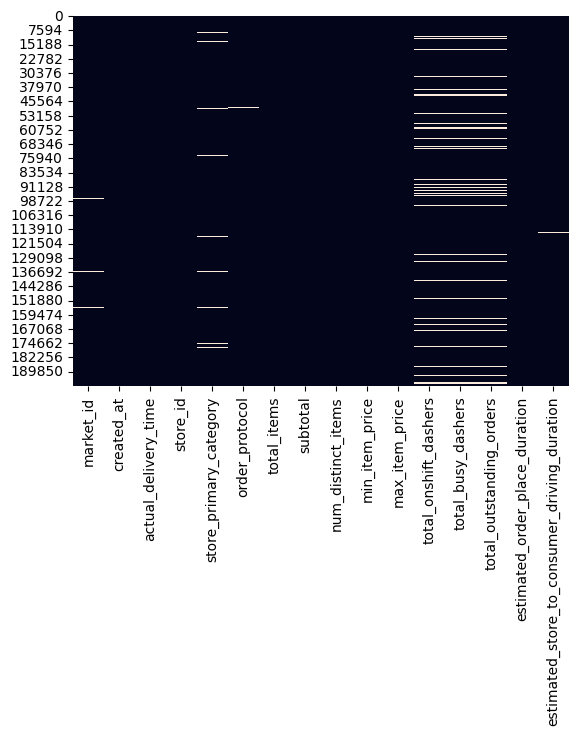

In [ ]:
missing_values = data_file.isnull().sum()
print(missing_values)
sns.heatmap(data_file.isnull(), cbar=False)

In [ ]:
### CLEANING & FEATURE ENGINEERING ###

data_file = data_file[(data_file['min_item_price'] >= 0) &
                      (data_file['total_onshift_dashers'] >= 0) &
                      (data_file['total_busy_dashers'] >= 0)]


data_file = data_file[data_file['subtotal'] > 0]


data_file.dropna(subset=['total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders'], inplace=True)


data_file['store_primary_category'].fillna('Unknown', inplace=True)


data_file['created_at'] = pd.to_datetime(data_file['created_at'], errors='coerce')
data_file['actual_delivery_time'] = pd.to_datetime(data_file['actual_delivery_time'], errors='coerce')



<ipython-input-3-f272d700b9db>:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_file['store_primary_category'].fillna('Unknown', inplace=True)


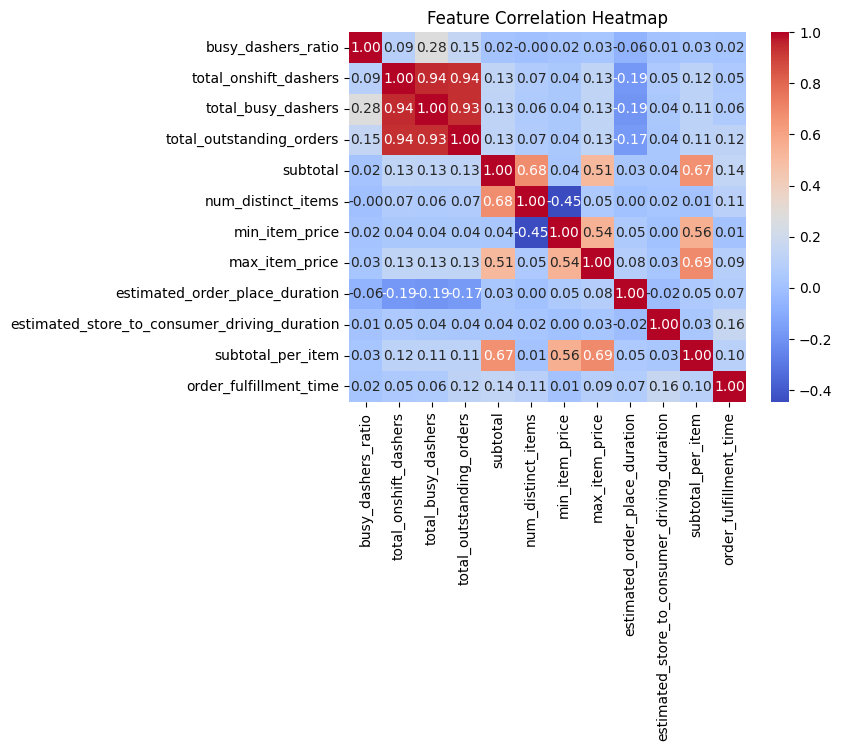

,market_id,actual_delivery_time,store_id,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,order_fulfillment_time,busy_dashers_ratio,subtotal_per_item
count,180029.000000,180941,180948.000000,180032.000000,180948.000000,180948.000000,180948.000000,180948.000000,180948.000000,180948.000000,180948.000000,180948.000000,180948.000000,180948.000000,180948.000000,180948.000000,180948.000000
mean,2.748902,2015-02-04 20:20:05.812895232,3545.234614,2.896302,3.208032,2701.038016,2.677692,684.773670,1160.749436,44.819965,41.750254,58.065925,308.839003,545.952761,2866.307990,0.886030,733.220553
min,1.000000,2015-01-21 15:58:11,1.000000,1.000000,1.000000,12.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-6.000000,0.000000,0.000000,101.000000,0.000000,6.000000
25%,2.000000,2015-01-29 02:25:06,1686.000000,1.000000,2.000000,1420.000000,2.000000,299.000000,799.000000,17.000000,15.000000,17.000000,251.000000,384.000000,2105.000000,0.771429,494.400000
50%,2.000000,2015-02-05 03:30:19,3614.000000,3.000000,3.000000,2225.000000,2.000000,595.000000,1095.000000,37.000000,34.000000,41.000000,251.000000,545.000000,2662.000000,0.916667,666.000000
75%,4.000000,2015-02-12 01:31:05,5323.000000,4.000000,4.000000,3415.000000,3.000000,942.000000,1395.000000,65.000000,62.000000,85.000000,446.000000,702.000000,3383.000000,0.981818,892.157143
max,6.000000,2015-02-19 22:45:31,6987.000000,7.000000,411.000000,26800.000000,20.000000,14700.000000,14700.000000,171.000000,154.000000,285.000000,2715.000000,2088.000000,373879.000000,29.000000,7350.000000
std,1.331675,NaN,2058.067461,1.515032,2.671361,1828.351517,1.627264,521.198207,561.791702,34.525963,32.143590,52.666346,90.326473,218.290458,1648.029276,0.354039,368.776429


In [ ]:
### CLEANING & FEATURE ENGINEERING ###

cleaned_data = data_file[data_file['total_onshift_dashers'] >= 0].dropna(subset=['total_onshift_dashers', 'created_at'])

cleaned_data.set_index('created_at', inplace=True)

cleaned_data['actual_delivery_time'] = pd.to_datetime(cleaned_data['actual_delivery_time'])
cleaned_data.index = pd.to_datetime(cleaned_data.index)

cleaned_data['order_fulfillment_time'] = (
    cleaned_data['actual_delivery_time'] - cleaned_data.index
).dt.total_seconds()

### RATIO FEATURES ###

cleaned_data['busy_dashers_ratio'] = cleaned_data['total_busy_dashers']/ (cleaned_data['total_onshift_dashers'] + 1)

cleaned_data['subtotal_per_item'] = cleaned_data['subtotal'] / (cleaned_data['num_distinct_items'] + 1)

### OTHER FEATURES



numeric_columns = [
    'busy_dashers_ratio','total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders',
    'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price',
    'estimated_order_place_duration', 'estimated_store_to_consumer_driving_duration',
    'subtotal_per_item', 'order_fulfillment_time'
]

cleaned_data.replace([np.inf, -np.inf], np.nan)
cleaned_data[numeric_columns] = cleaned_data[numeric_columns].apply(lambda col: col.fillna(col.mean()), axis=0)

# print(y.head())
# cleaned_data['order_fulfillment_time'].hist(bins=10000)
# plt.title('Distribution of Order Fulfillment Time')
# plt.xlabel('Order Fulfillment Time (seconds)')
# plt.ylabel('Frequency')
# plt.xlim(0,15000)
# plt.show()

sns.heatmap(cleaned_data[numeric_columns].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

cleaned_data.describe()

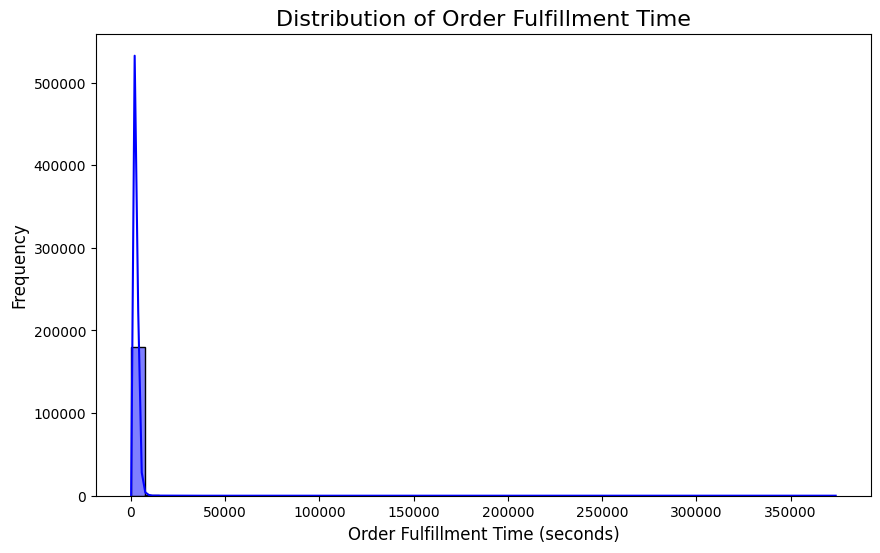

Summary Statistics for Order Fulfillment Time:
count    180948.000000
mean       2866.307990
std        1648.029276
min         101.000000
25%        2105.000000
50%        2662.000000
75%        3383.000000
max      373879.000000
Name: order_fulfillment_time, dtype: float64

Skewness: 108.81550349425123


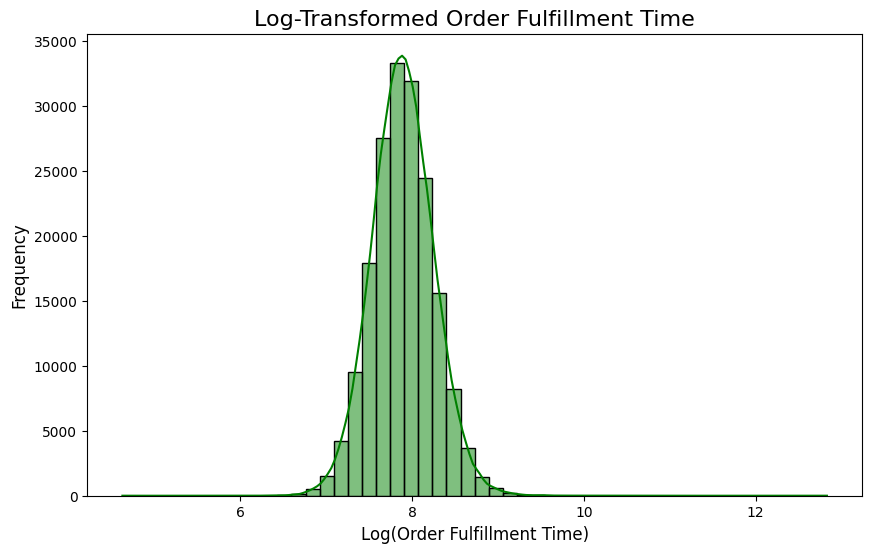

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(cleaned_data['order_fulfillment_time'], kde=True, bins=50, color='blue')
plt.title("Distribution of Order Fulfillment Time", fontsize=16)
plt.xlabel("Order Fulfillment Time (seconds)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show()

#summary statistics
target_stats = cleaned_data['order_fulfillment_time'].describe()
print("Summary Statistics for Order Fulfillment Time:")
print(target_stats)

#check skewness
from scipy.stats import skew

skewness = skew(cleaned_data['order_fulfillment_time'].dropna())

print(f"\nSkewness: {skewness}")

#log transformation
plt.figure(figsize=(10, 6))
sns.histplot(np.log1p(cleaned_data['order_fulfillment_time']), kde=True, bins=50, color='green')
plt.title("Log-Transformed Order Fulfillment Time", fontsize=16)
plt.xlabel("Log(Order Fulfillment Time)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show()


After analyzing the distribution of our target variable, we can see that order fulfillment times are heavily skewed to the right. Extreme values suggest there are outliers that may affect analysis. A log-transformed distribution appears to be normal, which is better. We will try to log the target variable and also perform a 0.99 percentile cutoff to reduce the impact of these extreme values, and compare.

Data Transformations

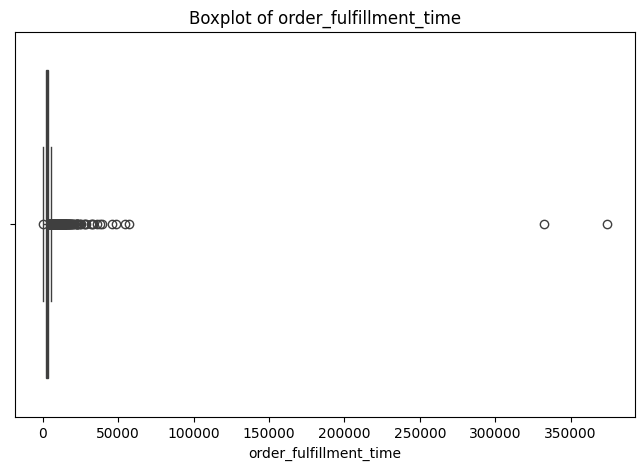

count    180948.000000
mean       2866.307990
std        1648.029276
min         101.000000
25%        2105.000000
50%        2662.000000
75%        3383.000000
max      373879.000000
Name: order_fulfillment_time, dtype: float64


<Figure size 800x500 with 0 Axes>

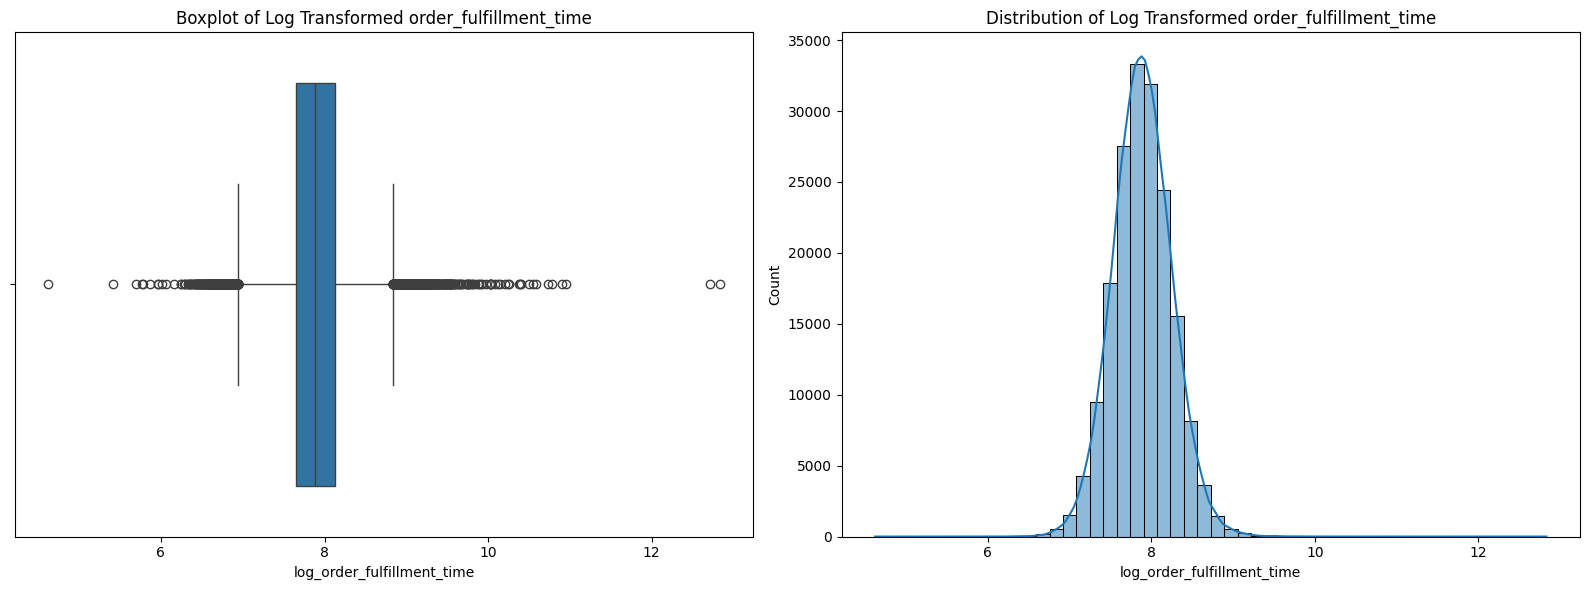

count    180948.000000
mean          7.892327
std           0.363246
min           4.624973
25%           7.652546
50%           7.887209
75%           8.126814
max          12.831690
Name: log_order_fulfillment_time, dtype: float64


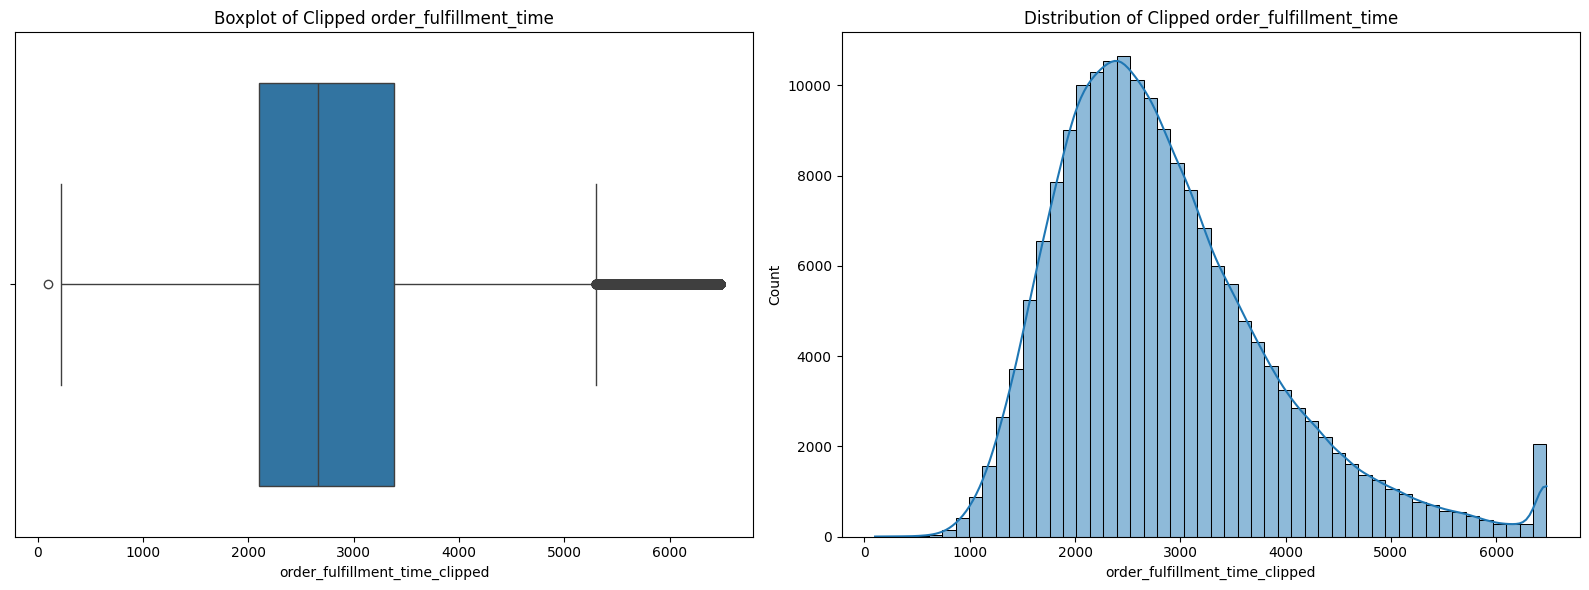

count    180948.000000
mean       2845.438150
std        1042.647236
min         101.000000
25%        2105.000000
50%        2662.000000
75%        3383.000000
max        6477.530000
Name: order_fulfillment_time_clipped, dtype: float64


In [ ]:
numeric_columns = [
    'busy_dashers_ratio','total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders',
    'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price',
    'estimated_order_place_duration', 'estimated_store_to_consumer_driving_duration',
    'subtotal_per_item'
]

cleaned_data['log_order_fulfillment_time'] = np.log1p(cleaned_data['order_fulfillment_time'])

### Log transform all predictors ###
#for col in numeric_columns:
#    cleaned_data[f'log_{col}'] = np.log1p(cleaned_data[col])
#log_transformed_data = np.log1p(cleaned_data[numeric_columns])

cleaned_data = cleaned_data.reset_index(drop=True)

#list of predictors to visualize


columns_to_check = ['order_fulfillment_time']
for col in columns_to_check:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=cleaned_data[col])
    plt.title(f'Boxplot of {col}')
    plt.show()
print(cleaned_data['order_fulfillment_time'].describe())

clipped_oft = f"order_fulfillment_time_clipped"
cleaned_data[clipped_oft] = cleaned_data['order_fulfillment_time'].clip(upper=cleaned_data['order_fulfillment_time'].quantile(0.99))

### BOXPLOT & DISTRIBUTION OF LOG OFT
plt.figure(figsize=(8, 5))
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # Create a 1x2 grid
sns.boxplot(x=cleaned_data['log_order_fulfillment_time'], ax=axes[0])
axes[0].set_title("Boxplot of Log Transformed order_fulfillment_time")

sns.histplot(cleaned_data['log_order_fulfillment_time'], kde=True, ax=axes[1], bins=50)
axes[1].set_title("Distribution of Log Transformed order_fulfillment_time")
plt.tight_layout()
plt.show()
print(cleaned_data['log_order_fulfillment_time'].describe())

### BOXPLOT & DISTRIBUTION OF CLIPPED OFT
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # Create a 1x2 grid
sns.boxplot(x=cleaned_data['order_fulfillment_time_clipped'], ax=axes[0])
axes[0].set_title("Boxplot of Clipped order_fulfillment_time")

sns.histplot(cleaned_data['order_fulfillment_time_clipped'], kde=True, ax=axes[1], bins=50)
axes[1].set_title("Distribution of Clipped order_fulfillment_time")

plt.tight_layout()
plt.show()

print(cleaned_data['order_fulfillment_time_clipped'].describe())

We can see that both log transforming and clipping the data achieve great results. We will now clip the whole of the cleaned data.

In [ ]:
### Add clipped version into cleaned data

percentile_99 = cleaned_data[numeric_columns].quantile(0.99)

for column in numeric_columns:
    clipped_col = f"{column}_clipped"
    cleaned_data[clipped_col] = cleaned_data[column].clip(upper=percentile_99[column])

print(cleaned_data.describe())

           market_id           actual_delivery_time       store_id  \
count  180029.000000                         180941  180948.000000   
mean        2.748902  2015-02-04 20:20:05.812895232    3545.234614   
min         1.000000            2015-01-21 15:58:11       1.000000   
25%         2.000000            2015-01-29 02:25:06    1686.000000   
50%         2.000000            2015-02-05 03:30:19    3614.000000   
75%         4.000000            2015-02-12 01:31:05    5323.000000   
max         6.000000            2015-02-19 22:45:31    6987.000000   
std         1.331675                            NaN    2058.067461   

       order_protocol    total_items       subtotal  num_distinct_items  \
count   180032.000000  180948.000000  180948.000000       180948.000000   
mean         2.896302       3.208032    2701.038016            2.677692   
min          1.000000       1.000000      12.000000            1.000000   
25%          1.000000       2.000000    1420.000000            2.0000

In [ ]:
### State variables for modeling
numeric_columns = [
    'busy_dashers_ratio','total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders',
    'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price',
    'estimated_order_place_duration', 'estimated_store_to_consumer_driving_duration',
    'subtotal_per_item'
]

clipped_numeric_columns = [
    'busy_dashers_ratio_clipped', 'total_onshift_dashers_clipped', 'total_busy_dashers_clipped',
    'total_outstanding_orders_clipped', 'subtotal_clipped', 'num_distinct_items_clipped',
    'min_item_price_clipped', 'max_item_price_clipped', 'estimated_order_place_duration_clipped',
    'estimated_store_to_consumer_driving_duration_clipped', 'subtotal_per_item_clipped'
]

data = cleaned_data[numeric_columns]
clipped_data = cleaned_data[clipped_numeric_columns]
X = data
X_clipped = clipped_data
y = np.log1p(cleaned_data['order_fulfillment_time_clipped'])

# Random Forest

Training RMSE: 0.24772557827414285
Testing RMSE: 0.29573851968342224
Training MAE: 0.1934300706174478
Testing MAE: 0.2324596731424826
Training R²: 0.5160316137127751
Testing R²: 0.32098198223774155


Training MAE (original scale): 543.57
Testing MAE (original scale): 652.59
Training RMSE (original scale): 753.82
Testing RMSE (original scale): 888.59

Feature Importances:
                                         Feature  Importance
9   estimated_store_to_consumer_driving_duration    0.204023
3                       total_outstanding_orders    0.202897
4                                       subtotal    0.144057
1                          total_onshift_dashers    0.116421
0                             busy_dashers_ratio    0.087835
2                             total_busy_dashers    0.069318
7                                 max_item_price    0.048674
10                             subtotal_per_item    0.045051
6                                 min_item_price    0.042648
8               

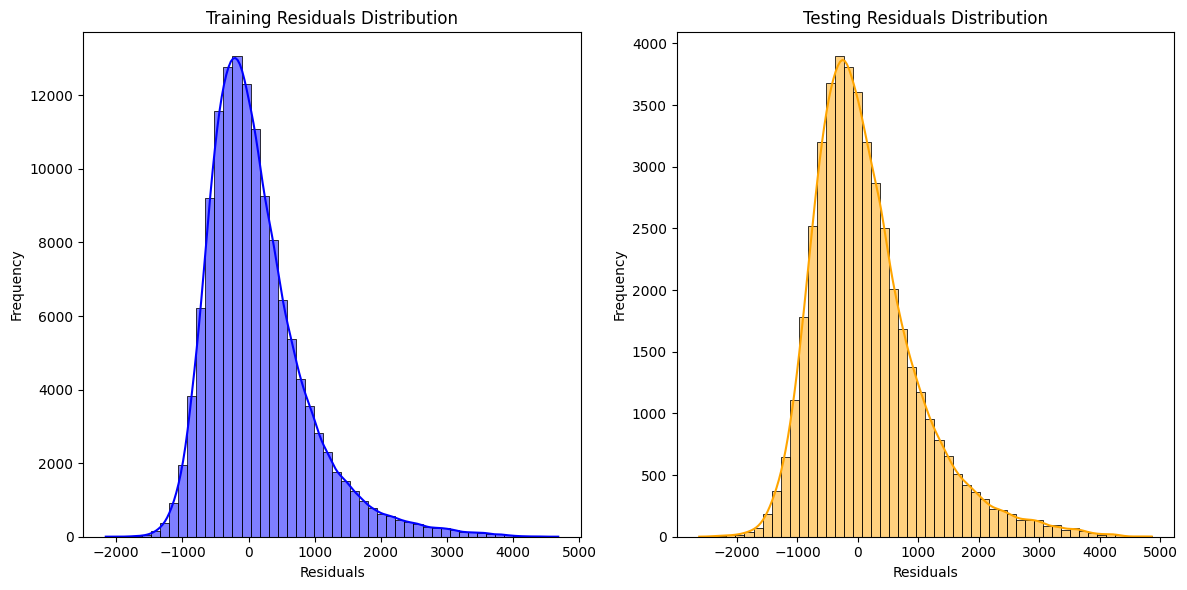

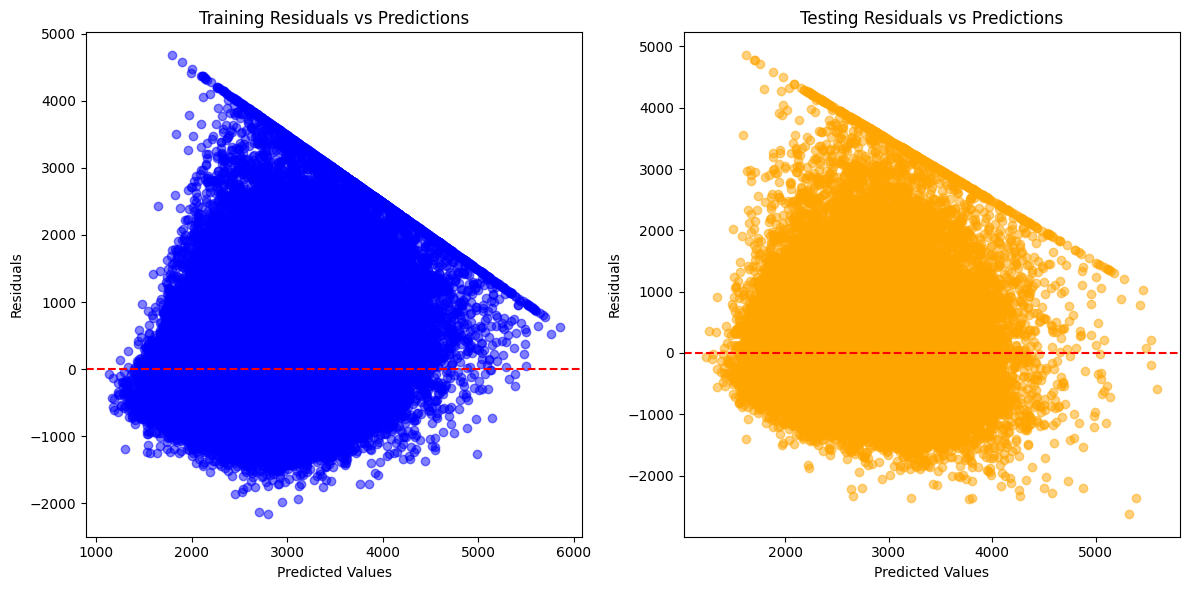

In [ ]:
from sklearn.model_selection import RandomizedSearchCV


########################################
### MOVED THESE INTO EDA SECTION
########################################

#X.replace([np.inf, -np.inf], np.nan, inplace=True)
#X = X.apply(lambda col: col.fillna(col.mean()), axis=0)
#X = X.reset_index(drop=True)
#y = np.nan_to_num(y, nan=np.nanmean(y, axis=0))

X_train, X_test, y_train, y_test = train_test_split(X_clipped, y, test_size=0.25, random_state=42)


X_sample = X_train.sample(frac=0.5, random_state=42)
y_sample = y_train.loc[X_sample.index]


### PERAMETER TUNING, COMMENTED OUT BECAUSE OF RUNTIME ###

'''
param_grid = {
    'n_estimators': [20, 35, 50],
    'max_depth': [20, 40, 50],
    'min_samples_split': [4, 5, 6, 7],
    'min_samples_leaf': [4, 5, 6, 7],
}

rf = RandomForestRegressor(random_state=42)

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=20,  # Number of different combinations to try
    cv=5,  # Number of cross-validation folds
    n_jobs=-1,
    random_state=42,
)

random_search.fit(X_sample, y_sample)
print("Best Parameters:", random_search.best_params_)
'''

#'''
model = RandomForestRegressor(
    random_state=42,
    n_estimators=100,
    max_depth=15,
    min_samples_split=6,
    min_samples_leaf=6
)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)

train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

### BACK TRANSFORM TRAINING & TEST ERRORS FOR INTERPRETABILITY
y_pred_train_back = np.expm1(y_pred_train)
y_train_back = np.expm1(y_train)
y_pred_test_back = np.expm1(y_pred_test)
y_test_back = np.expm1(y_test)

train_mae_back = np.mean(np.abs(y_pred_train_back - y_train_back))
train_rmse_back = np.sqrt(np.mean((y_pred_train_back - y_train_back)**2))

test_mae_back = np.mean(np.abs(y_pred_test_back - y_test_back))
test_rmse_back = np.sqrt(np.mean((y_pred_test_back - y_test_back)**2))

print("Training RMSE:", train_rmse)
print("Testing RMSE:", test_rmse)
print("Training MAE:", train_mae)
print("Testing MAE:", test_mae)
print("Training R²:", train_r2)
print("Testing R²:", test_r2)
print("\n")

print(f"Training MAE (original scale): {train_mae_back:.2f}")
print(f"Testing MAE (original scale): {test_mae_back:.2f}")
print(f"Training RMSE (original scale): {train_rmse_back:.2f}")
print(f"Testing RMSE (original scale): {test_rmse_back:.2f}")

feature_importances = pd.DataFrame({
    'Feature': numeric_columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importances)
#'''




residuals_train = y_train_back - y_pred_train_back
residuals_test = y_test_back - y_pred_test_back

# Plot residuals
plt.figure(figsize=(12, 6))

# Training Residuals
plt.subplot(1, 2, 1)
sns.histplot(residuals_train, kde=True, color='blue', bins=50)
plt.title('Training Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

# Testing Residuals
plt.subplot(1, 2, 2)
sns.histplot(residuals_test, kde=True, color='orange', bins=50)
plt.title('Testing Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Scatter Residuals vs Predictions
plt.figure(figsize=(12, 6))

# Training Residuals Scatter
plt.subplot(1, 2, 1)
plt.scatter(y_pred_train_back, residuals_train, alpha=0.5, color='blue')
plt.axhline(0, color='red', linestyle='--')
plt.title('Training Residuals vs Predictions')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

# Testing Residuals Scatter
plt.subplot(1, 2, 2)
plt.scatter(y_pred_test_back, residuals_test, alpha=0.5, color='orange')
plt.axhline(0, color='red', linestyle='--')
plt.title('Testing Residuals vs Predictions')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()